In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from utils import mat_to_pd, plot_mixtures

from drift_diffusion.model import DriftDiffusionModel
from drift_diffusion.sim import sample_from_pdf

# notebook defaults
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({"font.size": 10})
plot_fits_kwargs = dict(figsize=(10, 3), subplots=True, marker="o", ms=3, ls="none")
plot_acf_kwargs = dict(figsize=(10, 1.25), xlabel="lag(day)", lw=1, marker="o", ms=2)

# preprocess dataframe
df195 = (
    mat_to_pd("datasets/Rat195Vectors_241025.mat")
    .query("Valid == 1 and RT == RT")
    .assign(trialDate=lambda x: pd.to_datetime(x["trialDate"] - 719529, unit="D"))
    .set_index("trialDate")
    .sort_index()
    .loc["2008-10":]  # constant coherence of 0.85
    .assign(
        RT=lambda x: x["RT"] - x["RT"].min() + 1e-10,
        y=lambda x: x["RT"] * x["correct"].map({1: 1, 0: -1}),
        coh_bins=lambda x: pd.cut(x["coherence"], bins=5),
        day=lambda x: ((x.index - pd.Timedelta(hours=14)).floor("D") + pd.Timedelta(hours=14)),
    )
    .groupby("day")
    .filter(lambda x: x["RT"].count() > 50)  # filter out days with < 50 trials
)

coherence = 0.85

print(f"{df195["day"].nunique()} days, {df195.shape[0]} trials")

140 days, 58533 trials


rat 195: fit DDM by day

array([<Axes: xlabel='day'>, <Axes: xlabel='day'>], dtype=object)

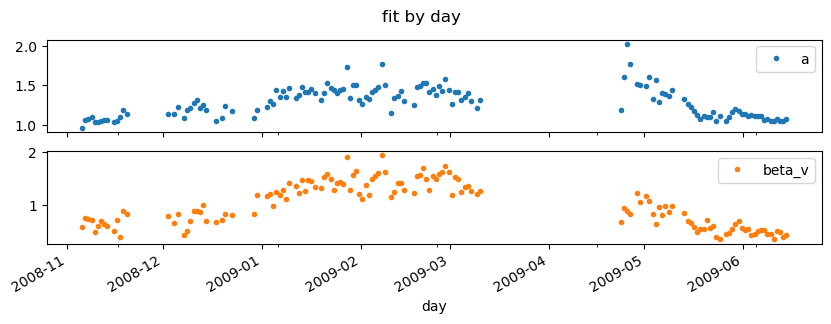

In [2]:
ddm = DriftDiffusionModel(a="+1", t0=0, v="-1 + coherence", z=0, cov_estimator="sample-hessian")
df195_fit_by_day = df195.groupby("day").apply(lambda grp: pd.Series(ddm.fit(grp, grp["y"]).params_, ["a", "beta_v"]))

# plot fits by day
df195_fit_by_day.plot(title="fit by day", **plot_fits_kwargs)

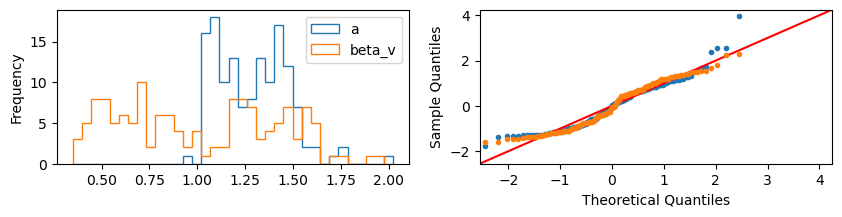

In [3]:
# plot distribution of fits by day
fig, axs = plt.subplots(ncols=2, figsize=(10, 2))
df195_fit_by_day.plot(kind="hist", histtype="step", bins=35, ax=axs[0])
_ = sm.qqplot(df195_fit_by_day["a"], fit=True, line="45", ax=axs[1], ms=3)
_ = sm.qqplot(
    df195_fit_by_day["beta_v"], fit=True, ax=axs[1], ms=3, markerfacecolor="#ff7f0e", markeredgecolor="#ff7f0e"
)

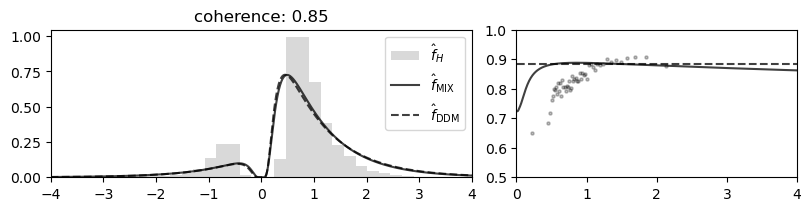

In [4]:
plot_mixtures(df195, df195_fit_by_day, coherence=coherence)

simulate mixtures: fit by day

array([<Axes: xlabel='day'>, <Axes: xlabel='day'>], dtype=object)

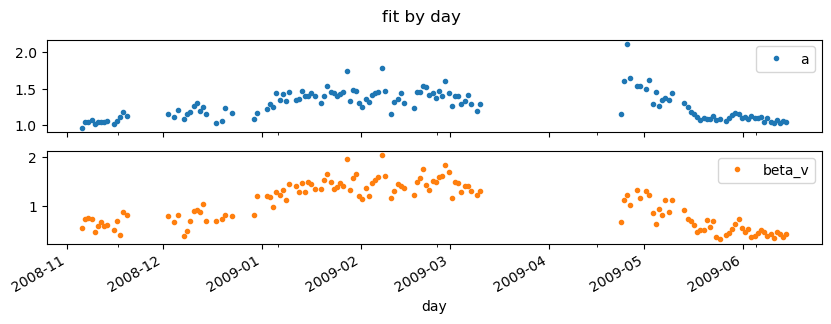

In [5]:
def sim_ddm(fit_by_day):
    df = {"y": [], "coherence": [], "day": []}
    for day, row in fit_by_day.iterrows():
        n_samples = df195.query("day == @day")["y"].count()
        y = sample_from_pdf(a=row["a"], t0=0, v=row["beta_v"] * coherence, z=0, n_samples=n_samples, random_state=0)
        df["y"].extend(y)
        df["coherence"].extend([coherence] * n_samples)
        df["day"].extend([day] * n_samples)
    return pd.DataFrame(df)


dfsim = sim_ddm(df195_fit_by_day)
dfsim_fit_by_day = dfsim.groupby("day").apply(lambda grp: pd.Series(ddm.fit(grp, grp["y"]).params_, ["a", "beta_v"]))

# plot fits by day
dfsim_fit_by_day.plot(title="fit by day", **plot_fits_kwargs)

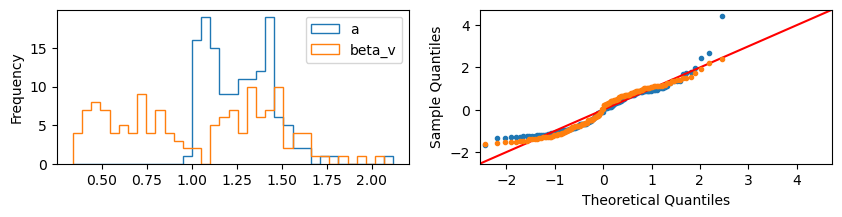

In [6]:
# plot distribution of fits by day
fig, axs = plt.subplots(ncols=2, figsize=(10, 2))
dfsim_fit_by_day.plot(kind="hist", histtype="step", bins=35, ax=axs[0])
_ = sm.qqplot(dfsim_fit_by_day["a"], fit=True, line="45", ax=axs[1], ms=3)
_ = sm.qqplot(
    dfsim_fit_by_day["beta_v"], fit=True, ax=axs[1], ms=3, markerfacecolor="#ff7f0e", markeredgecolor="#ff7f0e"
)

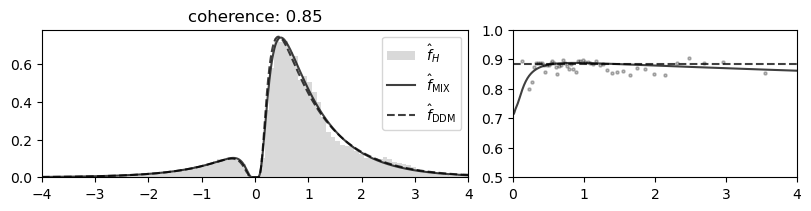

In [7]:
plot_mixtures(dfsim, dfsim_fit_by_day, coherence=coherence)